### LSTM MODEL BUILDING 2025 

In [1]:
import os
import pandas as pd
import Preprocessing_functions as pf  
import torch
import torch.nn as nn
import torch.optim 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime 
from pathlib import Path
#from Preprocessing_functions import min_max_scaling, create_multivariate_rnn_data, accuracy_fn, format_idx_date
#from torch.utils.data import DataLoader #, TensorDataset

In [2]:
# Prepare data for LSTM model
def prepare_data(data, sequence_length):
    import numpy as np
    y = data.pop('labels')
    
    data = data.dropna()
    
    features = list(data.columns)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[features])
    
     # Create sequences
    X, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X.append(X_scaled[i:i + sequence_length])
        y_seq.append(y.iloc[i + sequence_length - 1])

    return np.array(X), np.array(y_seq)


In [3]:
class CustomLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Args:
            input_size (int): The number of input features.
            hidden_sizes (list): A list of hidden sizes for each LSTM layer (e.g., [128, 64, 32]).
            output_size (int): The number of output features.
        """
        super(CustomLSTMModel, self).__init__()
        self.hidden_sizes = hidden_sizes
        
        # Define the first LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_sizes[0], batch_first=True)
        
        # Define subsequent LSTM layers
        self.lstm2 = nn.LSTM(hidden_sizes[0], hidden_sizes[1], batch_first=True)
        self.lstm3 = nn.LSTM(hidden_sizes[1], hidden_sizes[2], batch_first=True)
        
        # Fully connected layer for final output
        self.fc = nn.Linear(hidden_sizes[2], output_size)

    def forward(self, x):
        # Pass through the first LSTM layer
        out, _ = self.lstm1(x)
        
        # Pass through the second LSTM layer
        out, _ = self.lstm2(out)
        
        # Pass through the third LSTM layer
        out, _ = self.lstm3(out)
        
        # Pass the final output through the fully connected layer
        out = self.fc(out[:, -1, :])  # Use the last time-step's output
        return out

In [4]:

ticker = "SPY"

# LOAD DF FOR MODEL BUILDING 
FILE_PATH = f"Data/{ticker}/df/"
DF_FILES = os.listdir(FILE_PATH)
DF_FILES.remove('Junk')
print("DataFrames for model building: ", DF_FILES)
idx = 0 if len(DF_FILES) < 2 else int(input("Select file index: "))
DF_NAME = DF_FILES[idx] 
FILE_PATH_NAME = FILE_PATH + DF_NAME
FILE_PATH_NAME

DataFrames for model building:  ['df_SPY_k3_202402012133.parquet']


'Data/SPY/df/df_SPY_k3_202402012133.parquet'

In [5]:
df_model = pd.read_parquet(FILE_PATH_NAME)
df_model = df_model.reset_index()
df_model['Date'] = pd.to_datetime(df_model['Date']).dt.date
df_model = df_model.set_index("Date")
df_model = df_model.sort_index(ascending=False)

df_model.head()

,labels,open_low,open_close,gap,open_high,low_close,high_close,high_low,Dividends,Volume,...,SPY_mom3,SPY_mom4,SPY_mom5,SPY_mom10,SPY_mom15,SPY_mom20,SPY_mom60,SPY_mom120,SPY_mom180,SPY_mom240
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-01,1,0.171265,-0.538555,0.362409,-0.744898,-0.711038,-0.204817,0.909389,0.0,59327438,...,-0.82,-0.03,-0.16,2.26,2.24,3.94,12.54,10.10,19.31,21.15
2024-01-31,0,1.178830,1.174737,-0.462425,-0.094143,-0.004142,-1.267686,1.271776,0.0,126011100,...,-0.93,-1.06,-0.52,2.24,1.90,2.16,12.55,9.15,18.65,18.42
2024-01-30,2,0.091732,-0.067270,-0.144523,-0.216080,-0.159148,-0.148489,0.307148,0.0,58618400,...,0.59,1.13,1.24,3.36,3.43,3.28,16.61,10.22,20.46,20.77
2024-01-29,1,0.114818,-0.725811,0.065653,-0.756566,-0.841595,-0.030524,0.864841,0.0,61322800,...,1.21,1.32,1.62,3.06,4.99,3.06,17.95,9.83,20.34,20.81
2024-01-26,2,0.215345,0.036916,-0.090158,-0.313788,-0.178814,-0.349607,0.527478,0.0,76606300,...,0.53,0.82,1.03,2.32,4.31,2.29,17.76,9.92,19.96,21.27


# Prepare data for LSTM model

sequence_length = 3
data = df_model.copy()


import numpy as np
y = data.pop('labels')

data = data.dropna()

features = list(data.columns)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(data[features])
X_scaled = data[features]

#np.array(X), np.array(y_seq)

    # Create sequences
X, y_seq = [], []
for i in range(len(X_scaled) - sequence_length):
    X.append(X_scaled[i:i + sequence_length])
    y_seq.append(y.iloc[i + sequence_length - 1])


print(X)

In [6]:
# Training parameters
INPUT_SIZE = df_model.shape[0]
#HIDDEN_SIZE = 50
HIDDEN_SIZES = [128,64,32] # for custom lstm 
OUTPUT_SIZE = 3
#NUM_LAYERS = 2
EPOCHS = int(5e2)
LR = 0.001
SEQUENCE_LENGTH = 1

In [7]:

X, y = prepare_data(df_model, SEQUENCE_LENGTH)

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (2276, 1, 21)
y shape:  (2276,)


In [8]:
train_size_pct = 0.7

train_size = int(train_size_pct * X.shape[0])

X_train = X[ :train_size, :]
X_test = X[train_size :, :]

y_train = y[:train_size]
y_test = y[train_size:]

In [9]:
print('Training set start date: ', df_model.iloc[ :train_size, :].index.min())
print('Training set end date: ', df_model.iloc[ :train_size, :].index.max())
print('Test set start date: ', df_model.iloc[train_size :, :].index.min())
print('Test set end date: ', df_model.iloc[train_size :, :].index.max())

Training set start date:  2017-10-03
Training set end date:  2024-02-01
Test set start date:  2015-01-15
Test set end date:  2017-10-02


In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [11]:
model = CustomLSTMModel(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [12]:
os.getcwd()

'c:\\Users\\User\\Documents\\ATS_Development\\Strat_1'

In [13]:

results = {}

best_epoch = 0
best_accuracy = 0 
best_model_name = ''

# Training loop
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Evaluate on training set
    with torch.no_grad():
        train_predictions = outputs.argmax(dim=1)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_precision = precision_score(y_train, train_predictions, average='weighted', zero_division=0)
        train_recall = recall_score(y_train, train_predictions, average='weighted', zero_division=0)
        train_f1 = f1_score(y_train, train_predictions, average='weighted', zero_division=0)

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_predictions = val_outputs.argmax(dim=1)
        val_accuracy = accuracy_score(y_test, val_predictions)
        val_precision = precision_score(y_test, val_predictions, average='weighted', zero_division=0)
        val_recall = recall_score(y_test, val_predictions, average='weighted', zero_division=0)
        val_f1 = f1_score(y_test, val_predictions, average='weighted', zero_division=0)

    
    if val_accuracy > best_accuracy: 
        
        best_accuracy = val_accuracy
        best_epoch = epoch
        
        DATE = datetime.today().strftime('%Y%m%d%H%M')
        MODEL_PATH = Path(f"lstm_models/{ticker}")
        MODEL_PATH.mkdir(parents = True, exist_ok = True)
        
        # CREATE MODEL SAVE PATH
        MODEL_NAME = f"LSTM_Class_Epoch_{epoch}_TestAcc_{val_accuracy:.2f}_TrainAcc_{train_accuracy:.2F}_{DATE}"
        MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
        best_model_pathname = MODEL_SAVE_PATH
        # SAVE MODEL STATE DICT
        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)
        
        
    
    results[epoch]  = [(train_accuracy, val_accuracy)]
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Accuracy: {train_accuracy:.6f}, Train F1: {train_f1:.4f}, Val Accuracy: {val_accuracy:.6f}, Val F1: {val_f1:.4f}")

Saving model to: lstm_models\SPY\LSTM_Class_Epoch_0_TestAcc_0.23_TrainAcc_0.31_202501141259
Epoch [1/500], Train Accuracy: 0.311990, Train F1: 0.1484, Val Accuracy: 0.228404, Val F1: 0.0849
Saving model to: lstm_models\SPY\LSTM_Class_Epoch_1_TestAcc_0.78_TrainAcc_0.32_202501141259
Epoch [2/500], Train Accuracy: 0.315129, Train F1: 0.1572, Val Accuracy: 0.778917, Val F1: 0.7455
Epoch [3/500], Train Accuracy: 0.644068, Train F1: 0.5782, Val Accuracy: 0.724744, Val F1: 0.6242
Epoch [4/500], Train Accuracy: 0.583804, Train F1: 0.4669, Val Accuracy: 0.715959, Val F1: 0.6045
Epoch [5/500], Train Accuracy: 0.561205, Train F1: 0.4240, Val Accuracy: 0.710102, Val F1: 0.5912
Epoch [6/500], Train Accuracy: 0.554300, Train F1: 0.4098, Val Accuracy: 0.710102, Val F1: 0.5912
Epoch [7/500], Train Accuracy: 0.549906, Train F1: 0.4005, Val Accuracy: 0.710102, Val F1: 0.5912
Epoch [8/500], Train Accuracy: 0.547395, Train F1: 0.3951, Val Accuracy: 0.708638, Val F1: 0.5878
Epoch [9/500], Train Accuracy: 0

In [14]:
df_model.columns

Index(['open_low', 'open_close', 'gap', 'open_high', 'low_close', 'high_close',
       'high_low', 'Dividends', 'Volume', 'SPY_mom1', 'SPY_mom2', 'SPY_mom3',
       'SPY_mom4', 'SPY_mom5', 'SPY_mom10', 'SPY_mom15', 'SPY_mom20',
       'SPY_mom60', 'SPY_mom120', 'SPY_mom180', 'SPY_mom240'],
      dtype='object')

In [15]:
### LOAD THE BEST MDOEL
# LOAD LSTM MODEL STATE DICT  
model.load_state_dict(torch.load(f = best_model_pathname ))

<All keys matched successfully>

In [16]:
pd.DataFrame(val_predictions).value_counts()

2    476
1    165
0     42
Name: count, dtype: int64

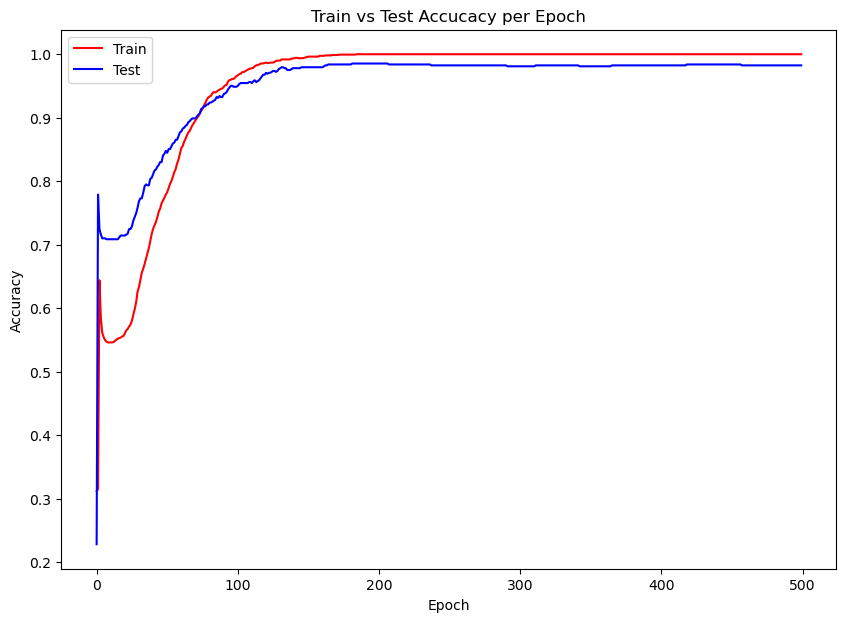

In [17]:

### plot training 
res = pd.DataFrame(results.values())
res.columns = ['tuple']

res['train_acc'] = res['tuple'].apply(lambda x : x[0])
res['test_acc'] = res['tuple'].apply(lambda x : x[1])

del res['tuple']
res.index = results.keys()


import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(res.index, res['train_acc'], color = 'red', label = 'Train')
plt.plot(res.index, res['test_acc'], color = 'blue', label = 'Test')
plt.title('Train vs Test Accucacy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()